In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("src")

from energy_es.data import PricesManager
from energy_es.ui.tools import get_time

In [3]:
# Get prices
pm = PricesManager()
prices = pm.get_prices()

In [4]:
# Format date
dt = prices[0]["datetime"]
dt = dt.strftime(f"%a %b {dt.day} %Y (%Z)")
dt

'Tue Dec 6 2022 (UTC+01:00)'

In [5]:
# Create X axis values
x = list(map(lambda x: get_time(x["datetime"]), prices))
x = np.array(x)
x

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype='<U5')

In [6]:
# Create Y axis values
y = list(map(lambda x: x["value"], prices))
y = np.array(y)
y

array([156.51, 153.12, 148.21, 148.21, 148.75, 153.22, 148.21, 131.3 ,
       132.  , 142.11, 148.82, 148.32, 150.01, 154.27, 153.38, 148.21,
       154.27, 148.21, 164.  , 182.75, 194.83, 182.75, 156.51, 134.7 ])

In [7]:
# Minimum price
min_price = min(prices, key=lambda x: x["value"])
min_x = get_time(min_price["datetime"])
min_y = min_price["value"]
min_x, min_y

('07:00', 131.3)

In [8]:
# Maximum price
max_price = max(prices, key=lambda x: x["value"])
max_x = get_time(max_price["datetime"])
max_y = max_price["value"]
max_x, max_y

('20:00', 194.83)

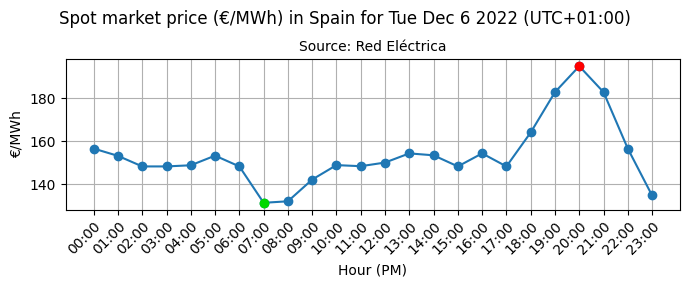

In [9]:
# Create chart
fig, ax = plt.subplots(figsize=(7, 3))
fig.suptitle(f"Spot market price (€/MWh) in Spain for {dt}", y=0.94)

ax.set_title("Source: Red Eléctrica", fontdict={"fontsize": 10})
ax.plot(x, y, marker="o")
ax.scatter([min_x], [min_y], c="#00d800", zorder=2)
ax.scatter([max_x], [max_y], c="#ff0000", zorder=2)

ax.set(xlabel="Hour (PM)", ylabel="€/MWh")
ax.grid()

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.show()